#  ATOC5860 Application Lab #5 - synthetic data_with_filters
##### Written by Prof. Barnes (CSU) with additional commenting by Prof. Kay (CU) and Prof. Maroon (UWisc)
##### last updated April 6, 2023 - works with environment atoc5860env2023clean.yml

<font color='green'> Questions answered by Clairy Reiher (last answered on Fri, Apr 14, 2022).

### LEARNING GOALS:
1) Apply both non-recursive and recursive filters to a synthetic dataset
2) Contrast the influence of applying different non-recursive filters including the 1-2-1 filter, 1-1-1 filter, the 1-1-1-1-1 filter, and the Lanczos filter.
3) Investigate the influence of changing the window and cutoff on Lanczos smoothing.

### DATA and UNDERLYING SCIENCE MOTIVATION:  

In this notebook, you analyze a timeseries with known properties.  You will apply filters of different types and assess their influence on the resulting filtered dataset.

**Questions to guide your analysis** 

1) Create a red noise timeseries with oscillations. Plot your synthetic data – Look at your data!!  Look at the underlying equation. What type of frequencies might you expect to be able to remove with filtering?
    
<font color='green'> The red noise time series is essentially a combination of oscillations at two different frequencies (a low frequency and a high frequency) with a modest amount of white noise thrown in. A low-pass filter could be used to remove the white noise, or even the higher frequency specified in the equation for the red noise time series. 

2) Apply non-recursive filters in the time domain (i.e., apply a moving average to the original data) to reduce power at high frequencies.  Compare the filtered time series with the original data (top plot).  Look at the moving window weights (bottom plot).   You are using the function “filtfilt” from scipy.signal, which applies both a forward and a backward running average.  Try different filter types – What is the influence of the length of the smoothing window or weighted average that is applied (e.g., 1-1-1 filter vs. 1-1-1-1-1 filter)?  What is the influence of the amplitude of the smoothing window or the weighted average that is applied (e.g., 1-1-1 filter vs. 1-2-1 filter)?  Tinker with different filters and see what the impact is on the filtering that you obtain.
    
<font color='green'> A longer smoothing window seems to reduce the noise in the time series. In other words, a longer smoothing window seems to dampen the shorter (higher) frequencies to a greater extent. A larger amplitude in the smoothing window seems to permit a larger amplitude in the low frequency perturbations present in the time series, and also permits smoothing.

3) Apply a Lanczos filter to remove high frequency noise (i.e., to smooth the data).  What is the influence of increasing/decreasing the window length on the smoothing and the response function (Moving Window Weights) in the Lanczos filter?  What is the influence of increasing/decreasing the cutoff on the smoothing and the response function?
    
<font color='green'> Increasing the window length causes the central point in the moving window to be weighted more heavily relative to its neighboring points. Increasing the cutoff frequency also causes the central point to be weighted relatively more heavily. At a higher cutoff frequency, this window length has a smaller influence on the amount of smoothing that occurs.

4) Apply a Butterworth filter, a recursive filter.  Compare the response function (Moving Window Weights) with the non-recursive filters analyzed above.
    
<font color='green'> The moving window weights generated using the Butterworth filter allow for a smoother decrease in weight on either side of the central data point within the window than when a simple weighted average is applied. The Lanczos filter can provide a relatively smooth series of moving window weight depending on the inputs (window length and cutoff frequency), and the weights generated by the Lanczos filter can also assign more weight to points on the edges of the window than the Butterworth filter does.

In [2]:
#Import functions
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.signal as sig
from matplotlib.gridspec import GridSpec
import timeit
import scipy.io as sio

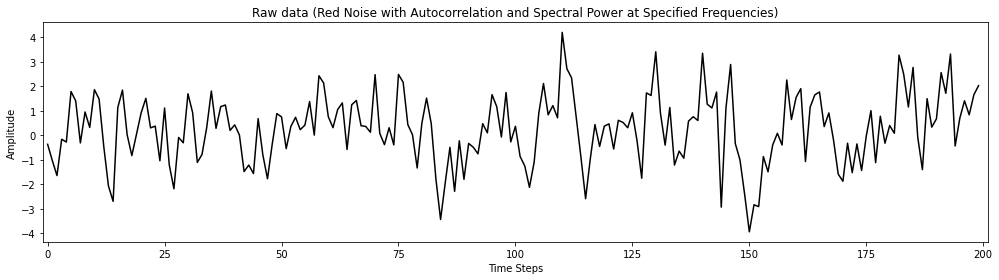

In [3]:
#Generate an anomaly red noise time series with oscillations
#This is essentially red noise composed of noisy sine waves at two different frequencies
#Note: the addition of the randomized white noise in the way done blow adds extra power 
#at higher frequencies, and also modifies the sine waves with f = freq and f = freq2 some 

n = 200              ## number of time steps
alpha = 0.5          ## autocorrelation
freq = 0.2           ## oscillation frequency (lower/slower)
freq2 = 0.4          ## oscillation frequency (higher/faster)
factor = np.sqrt(1.-alpha*alpha)
x = np.zeros((n,))
pnum = 0
x[0] = x[-1]*alpha + factor*np.random.randn()
for j in np.arange(1,n):
    x[j] = x[j-1]*alpha + factor*np.random.randn()+1.0*np.cos(2.0*np.pi*(1.0-0.01*np.random.randn())*freq*j) + \
    0.75*np.cos(2.*np.pi*(1.-.001*np.random.randn())*freq2*j-np.pi/4.) 
    
#Calculate the anomaly by removing the mean  
xa = x - np.mean(x) 

#Plot the time series generated above
f=plt.figure(figsize=(14,4))
plt.plot(x,'-k',linewidth = 1.5, label = 'raw input');
plt.xlim(-1,np.size(x)+1);
plt.title('Raw data (Red Noise with Autocorrelation and Spectral Power at Specified Frequencies)');
plt.xlabel('Time Steps');
plt.ylabel('Amplitude');
f.tight_layout()
plt.show()

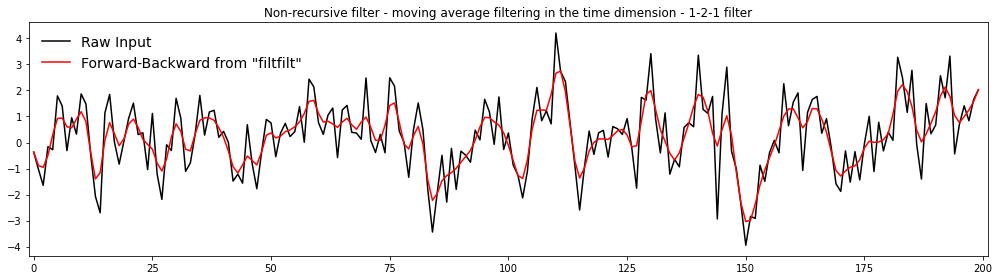

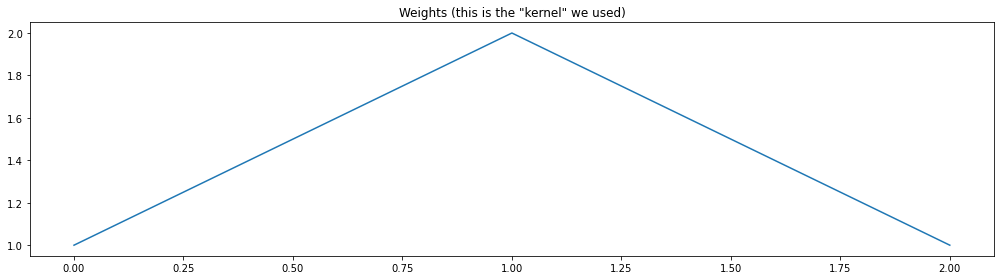

In [4]:
#Apply a non-recursive filter in the time dimension
#This filter is also called a "moving average filter"
#You can also try multiple non-recursive filter types

#Filter type #1: apply a 1-2-1 filter in the time dimension, which is just a non-recursive 
#moving average filter
#So when computing the new filtered time series at a given point, we are weighting the
#the value at that point twice as much as the value at the point to the left and the value
#at the point to the right, which are also being included in this average
f=plt.figure(figsize=(14,4))
plt.plot(x,'-k',linewidth = 1.5, label = 'Raw Input');

#The format of the inputs in sig.filtfilt() is (numerator, denomenator, data)
#The variable "b" sets the moving average "kernel" that we are using
b = (1,2,1)
y = sig.filtfilt(b,np.sum(b),x)

plt.plot(y,'-r', label = 'Forward-Backward from "filtfilt"')
plt.xlim(-1,np.size(x)+1)
plt.legend(frameon = False, fontsize = 14,loc='upper left')
plt.title('Non-recursive filter - moving average filtering in the time dimension - 1-2-1 filter')
f.tight_layout()

f=plt.figure(figsize=(14,4))
plt.plot(b);
plt.title('Weights (this is the "kernel" we used)')
f.tight_layout()

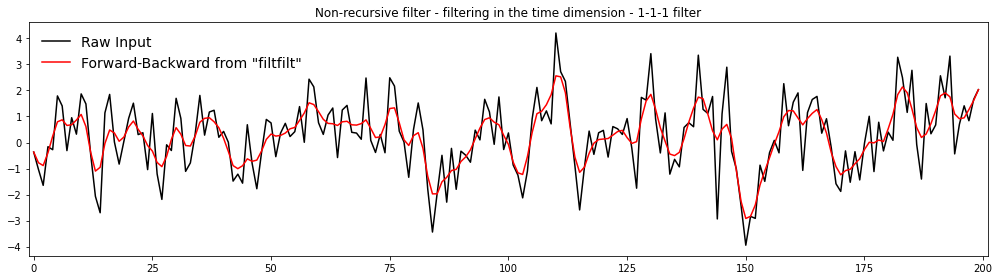

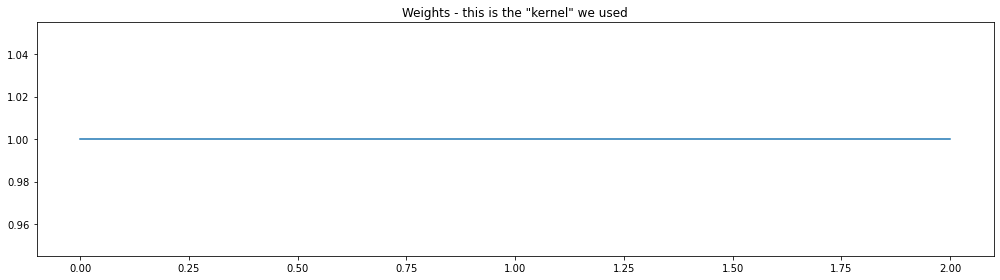

In [5]:
#Filter type #2: apply a 1-1-1 filter
#Another example of a non-recursive moving average filter applied in the time dimension

f=plt.figure(figsize=(14,4))
plt.plot(x,'-k',linewidth = 1.5, label = 'Raw Input');

#Apply the filter to obtain a new filtered time series y
b = (1,1,1)
y = sig.filtfilt(b,np.sum(b),x)

plt.plot(y,'-r', label = 'Forward-Backward from "filtfilt"')
plt.xlim(-1,np.size(x)+1)
plt.legend(frameon = False, fontsize = 14,loc='upper left')
plt.title('Non-recursive filter - filtering in the time dimension - 1-1-1 filter')
f.tight_layout()

f=plt.figure(figsize=(14,4))
plt.plot(b);
plt.title('Weights - this is the "kernel" we used')
f.tight_layout()

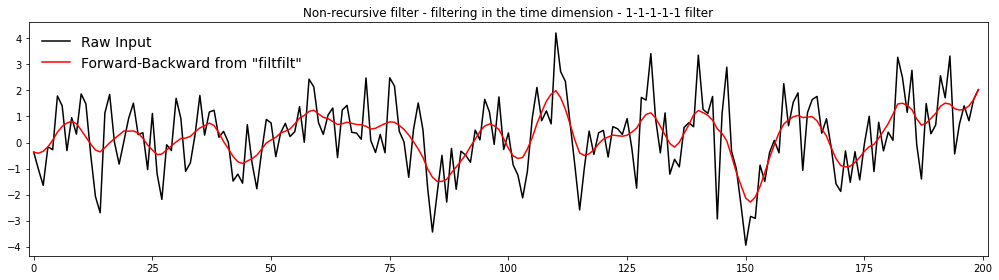

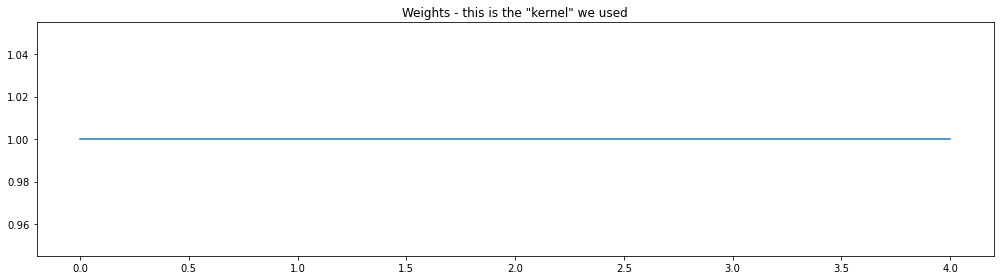

In [6]:
#Filter type #3: apply a 1-1-1-1-1 filter
#Another example of a non-recursive moving average filter applied in the time dimension

f=plt.figure(figsize=(14,4))
plt.plot(x,'-k',linewidth = 1.5, label = 'Raw Input');

#Apply the filter to obtain a new filtered time series y
b = (1,1,1,1,1)
y = sig.filtfilt(b,np.sum(b),x)

plt.plot(y,'-r', label = 'Forward-Backward from "filtfilt"')
plt.xlim(-1,np.size(x)+1)
plt.legend(frameon = False, fontsize = 14,loc='upper left')
plt.title('Non-recursive filter - filtering in the time dimension - 1-1-1-1-1 filter')
f.tight_layout()

f=plt.figure(figsize=(14,4))
plt.plot(b);
plt.title('Weights - this is the "kernel" we used')
f.tight_layout()

oscillation frequency synthetic data (per timestep): 0.2
frequency cutoff (per timestep): 0.09090909090909091


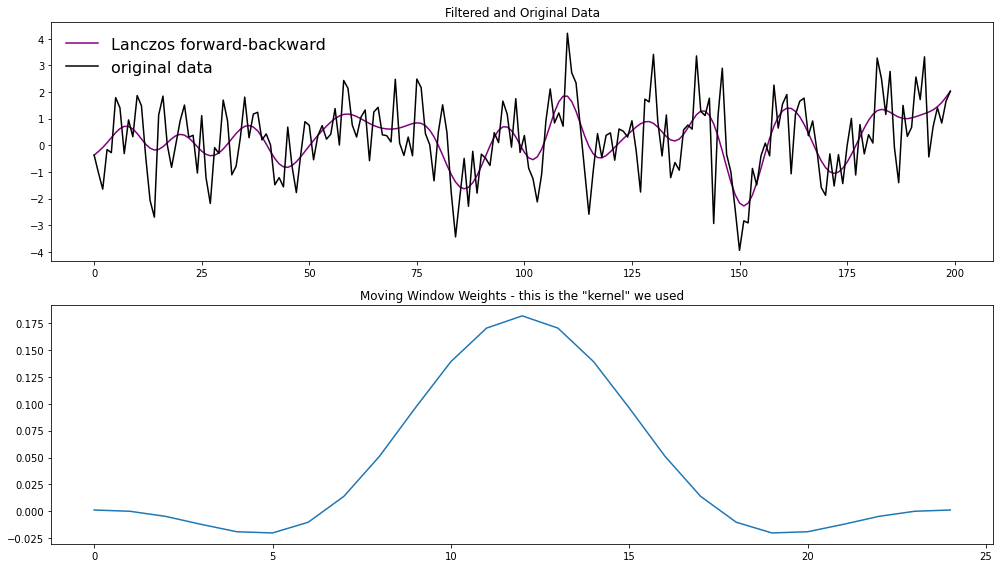

In [21]:
#Filter type #4: Lanczos Filter (non-recursive)
#This is a very standard non-recursive filter that gets applied in the time dimension

#Function to make window for Lanczos Filter
def low_pass_weights(window, cutoff):
    
    #Calculate weights for a low pass Lanczos filter.
    #Args:
    #window: int
        #The length of the filter window in time steps
    #cutoff: float
        #The cutoff frequency in inverse time steps. 
        #(e.g., for data collected every hour, frequency units are per hour)
        
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k) 
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma    
    return w[1:-1]

#Specify the window length for filters
window = 25 #default is 25
cutoff = 1.0/11.0 #default is 1.0/11.0
wgts24 = low_pass_weights(window, cutoff)
print('oscillation frequency synthetic data (per timestep): '+str(freq))
print('frequency cutoff (per timestep): '+str(cutoff))

f=plt.figure(figsize=(14,8))
gs=GridSpec(2,1)
fig=plt.subplot(gs[0,0])

#Apply the filter in the forward and backward direction using the weights we
#constructed above
y = sig.filtfilt(wgts24,np.sum(wgts24),x)

plt.plot(y, color = 'purple', label = 'Lanczos forward-backward');
plt.plot(x,'-k',linewidth = 1.5, label = 'original data');
plt.title('Filtered and Original Data')
plt.legend(frameon = False, fontsize = 16);

fig=plt.subplot(gs[1,0])
plt.plot(wgts24);
plt.title('Moving Window Weights - this is the "kernel" we used')
f.tight_layout()

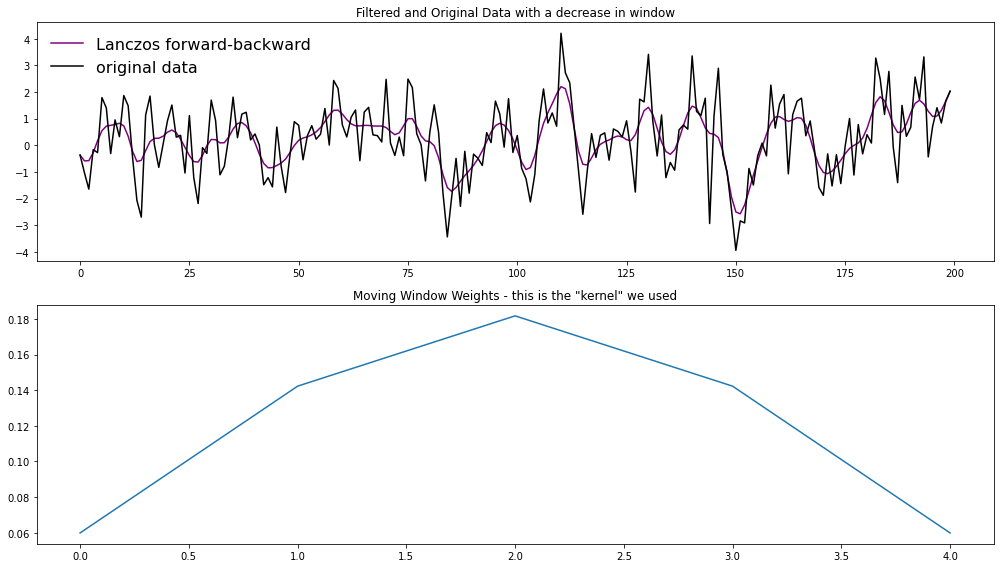

In [18]:
#Now try changing the window length for the Lanczos filter applied below
#Decreasing the window (for example to 5) means less smoothing
#Increasing the window (for example to 50) means more smoothing
window = 5
cutoff = 1.0/11.0 #Default = 1.0/11.0
wgts24 = low_pass_weights(window, cutoff)

f=plt.figure(figsize=(14,8))
gs=GridSpec(2,1)
fig=plt.subplot(gs[0,0])

#Apply the filter in the forward and backward direction using the weights we
#constructed above
y = sig.filtfilt(wgts24,np.sum(wgts24),x)

plt.plot(y, color = 'purple', label = 'Lanczos forward-backward');
plt.plot(x,'-k',linewidth = 1.5, label = 'original data');
plt.title('Filtered and Original Data with a decrease in window')
plt.legend(frameon = False, fontsize = 16);
fig=plt.subplot(gs[1,0])
plt.plot(wgts24);
plt.title('Moving Window Weights - this is the "kernel" we used')
f.tight_layout()

oscillation frequency synthetic data: 0.2
frequency cutoff: 0.2


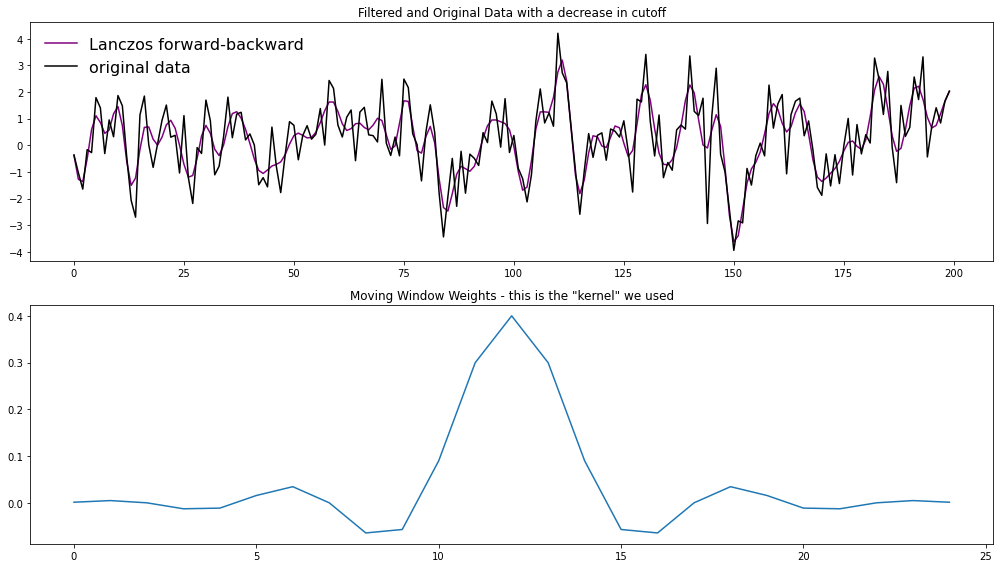

In [14]:
#Now try changing the cutoff for the Lanczos filter applied below
#If you increase the cutoff frequency, the weight is concentrated in the middle of the window
#If you decrease the cutoff frequency, more weight concentrated at the end of the window
window = 25 ## default 25
cutoff = 20.0/100.0
wgts24 = low_pass_weights(window, cutoff)

print('oscillation frequency synthetic data: '+str(freq))
print('frequency cutoff: '+str(cutoff))

f=plt.figure(figsize=(14,8))
gs=GridSpec(2,1)
fig=plt.subplot(gs[0,0])
y = sig.filtfilt(wgts24,np.sum(wgts24),x)
plt.plot(y, color = 'purple', label = 'Lanczos forward-backward');
plt.plot(x,'-k',linewidth = 1.5, label = 'original data');
plt.title('Filtered and Original Data with a decrease in cutoff')
plt.legend(frameon = False, fontsize = 16);
fig=plt.subplot(gs[1,0])
plt.plot(wgts24);
plt.title('Moving Window Weights - this is the "kernel" we used')
f.tight_layout()

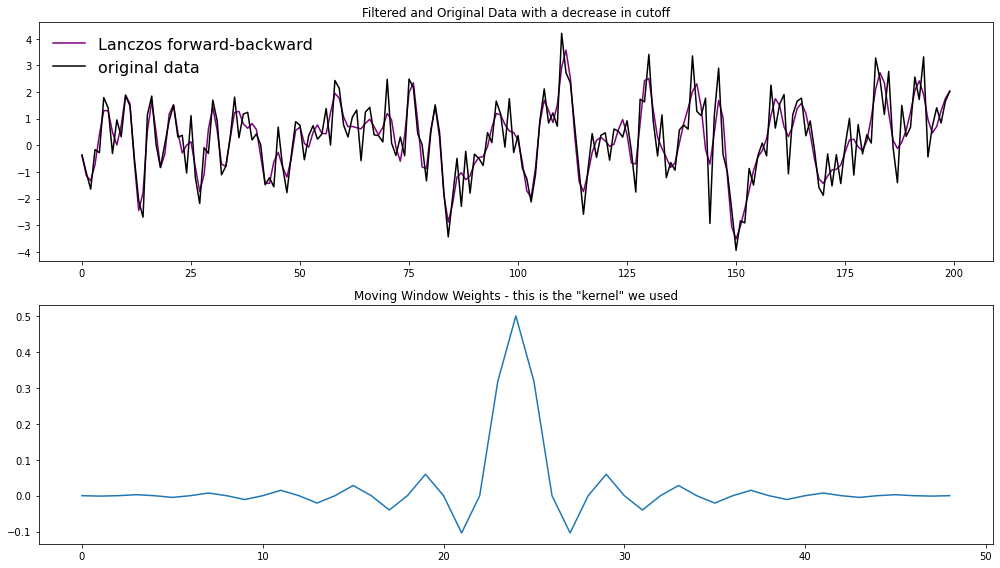

In [15]:
#Continue changing the window length and curoff for filters at different frequencies
#With a lower cutoff frequency, the window length has a bigger influence on the amount of smoothing
window = 50
cutoff = 25.0 / 100.0
wgts24 = low_pass_weights(window, cutoff)

f=plt.figure(figsize=(14,8))
gs=GridSpec(2,1)
fig=plt.subplot(gs[0,0])
y = sig.filtfilt(wgts24,np.sum(wgts24),x)
plt.plot(y, color = 'purple', label = 'Lanczos forward-backward');
plt.plot(x,'-k',linewidth = 1.5, label = 'original data');
plt.title('Filtered and Original Data with a decrease in cutoff')
plt.legend(frameon = False, fontsize = 16);
fig=plt.subplot(gs[1,0])
plt.plot(wgts24);
plt.title('Moving Window Weights - this is the "kernel" we used')
f.tight_layout()

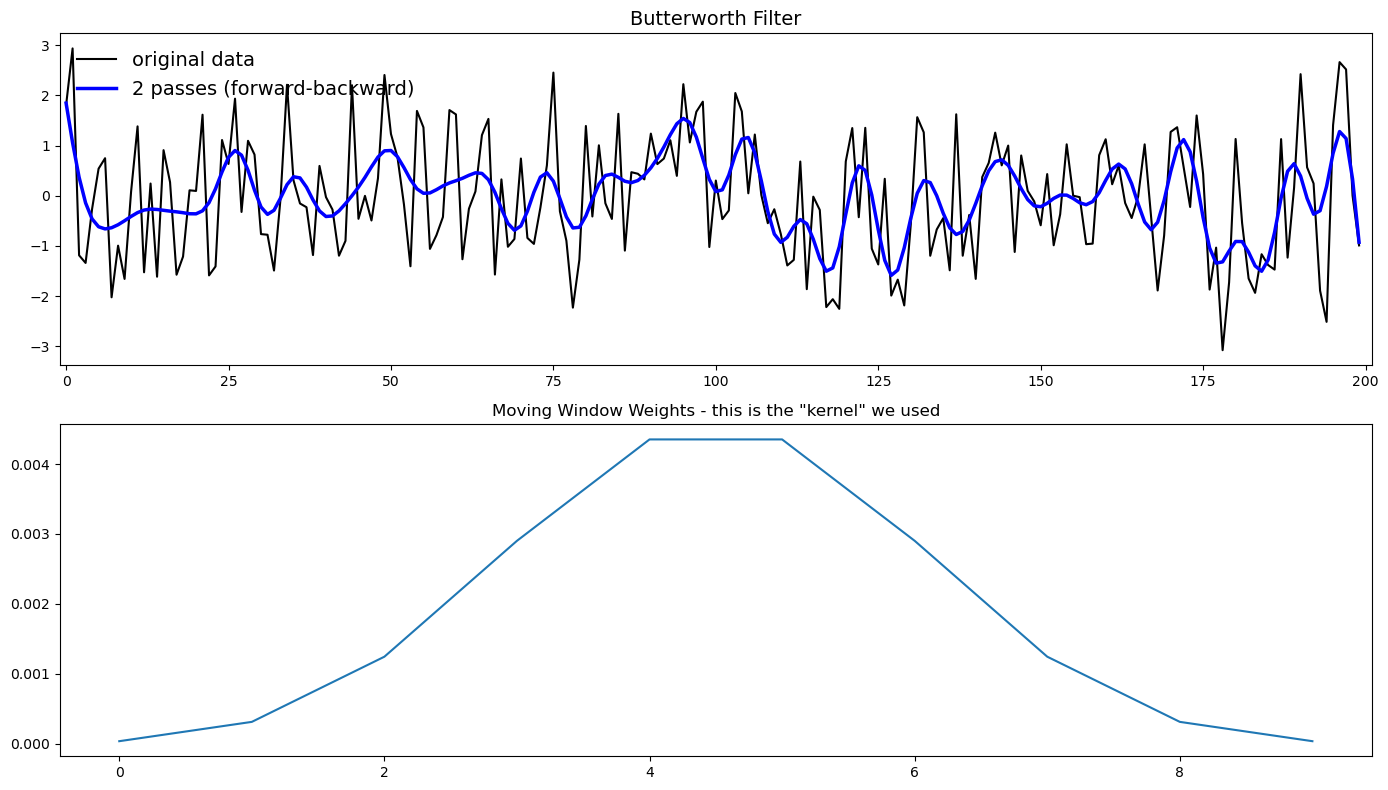

In [10]:
#Compare the above results to results from applying a recursive filter...

#Note: Wn is normalized from 0 to 1, where 1 is the Nyquist frequency, pi radians/sample (so
#it's in units of half-cycles per sample) 

#Here we apply the Butterworth filter of actual data
N = 9 #Order
Wn = 0.25 #Scalar of the critical frequency (all higher frequencies are removed)

b, a = sig.butter(N, Wn)
y = sig.filtfilt(b,a,xa) ## one filter forward, one filter backward - you are filtering twice

f=plt.figure(figsize=(14,8))
gs=GridSpec(2,1)
fig=plt.subplot(gs[0,0])
plt.plot(x,'-k',linewidth = 1.5, label = 'original data');
plt.plot(y,'-b',linewidth = 2.5, label = '2 passes (forward-backward)');
plt.title('Butterworth Filter',fontsize=14)
plt.legend(frameon = False,fontsize = 14,loc='upper left')
plt.xlim(-1,np.size(x)+1)
fig=plt.subplot(gs[1,0])
plt.plot(b);
plt.title('Moving Window Weights - this is the "kernel" we used')
f.tight_layout()